In [1]:
import torch
import torch.nn
import torch.nn.functional
import pyro
import pyro.distributions
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import rasterio
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout


In [2]:
os.chdir(r'C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\3_Data_Download\3_All_Rasters')

In [ ]:
data_dir = r"C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\3_Data_Download\3_All_Rasters"

filenames = [
    "Final_Temperature_min.tif",
    "Final_Longwave_radiation_Stacked.tif",
    "Final_Precipitaion_stacked.tif",
    "Final_shortwave_radiation_Stacked.tif",
    "Final_Temperature_max.tif",
    "Final_Wind_Stacked.tif",
    "Final_snodas_Stacked.tif"
]

file_paths = [os.path.join(data_dir, f) for f in filenames]

data_list = []
for fp in file_paths:
    with rasterio.open(fp) as src:
        arr = src.read()
        data_list.append(arr)
        print(f"Read {fp} with shape {arr.shape}")

num_days = data_list[0].shape[0] 
height = data_list[0].shape[1]
width = data_list[0].shape[2] 
num_vars = len(data_list)   
images = np.stack([
    np.stack([data_list[var_idx][day, :, :] for var_idx in range(num_vars)], axis=-1)
    for day in range(num_days)
], axis=0)
print("Combined images shape:", images.shape) 

images = np.nan_to_num(images, nan=0.0)

images_min = np.nanmin(images, axis=(0, 1, 2), keepdims=True)
images_max = np.nanmax(images, axis=(0, 1, 2), keepdims=True) 
images_norm = (images - images_min) / (images_max - images_min)

# Check normalization
print("Min value in images_norm:", np.min(images_norm))
print("Max value in images_norm:", np.max(images_norm))

def build_cnn_feature_extractor(input_shape):
    model = Sequential([
        Conv2D(64, (5, 5), activation='relu', padding="same", input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),  # Helps prevent overfitting
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(8, activation='linear')  # Change "linear" to "relu"
    ])
    return model


cnn_input_shape = (height, width, num_vars)
cnn_model = build_cnn_feature_extractor(cnn_input_shape)

cnn_model.summary()
features = np.zeros((num_days, 8)) 

for i in range(num_days):
    image = images_norm[i:i+1]  
    feature_vector = cnn_model.predict(image) 
    features[i] = feature_vector

print("CNN features shape:", features.shape) 

feature_df = pd.DataFrame(features, columns=filenames)
print("Feature DataFrame shape:", feature_df.shape)
print(feature_df.head())


Read C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\3_Data_Download\3_All_Rasters\Final_evaporation_Stacked.tif with shape (7763, 31, 33)
Read C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\3_Data_Download\3_All_Rasters\Final_Humidity_Stacked.tif with shape (7763, 31, 33)
Read C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\3_Data_Download\3_All_Rasters\Final_Longwave_radiation_Stacked.tif with shape (7763, 31, 33)
Read C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\3_Data_Download\3_All_Rasters\Final_Precipitaion_stacked.tif with shape (7763, 31, 33)
Read C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\3_Data_Download\3_All_Rasters\Final_shortwave_radiation_Stacked.tif with shape (7763, 31, 33)
Read C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\3_Data_Download\3_All_Rasters\Final_Temperature_Stacked.tif with shape (7763, 31, 33)
Read C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\3_Data_Do

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 31, 33, 64)     │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 31, 33, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 15, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785,800 (3.00 MB)

 Trainable params: 784,904 (2.99 MB)

 Non-trainable params: 896 (3.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

Epoch 1/50


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


384/384 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - loss: 0.0102 - val_loss: 0.0062
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 8/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 9/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 10/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 11/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 12/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 

c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



🔵 **Calibration (Training) Data Performance**
Mean Absolute Error (MAE): 76.2163
Root Mean Squared Error (RMSE): 123.3211
R² Score: 0.9319
Nash-Sutcliffe Efficiency (NSE): 0.9319
Kling-Gupta Efficiency (KGE): nan
Percent Bias (PBIAS): 6.9596

🔵 **Validation (Testing) Data Performance**
Mean Absolute Error (MAE): 69.4308
Root Mean Squared Error (RMSE): 111.3224
R² Score: 0.9475
Nash-Sutcliffe Efficiency (NSE): 0.9475
Kling-Gupta Efficiency (KGE): nan
Percent Bias (PBIAS): 4.9107


c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


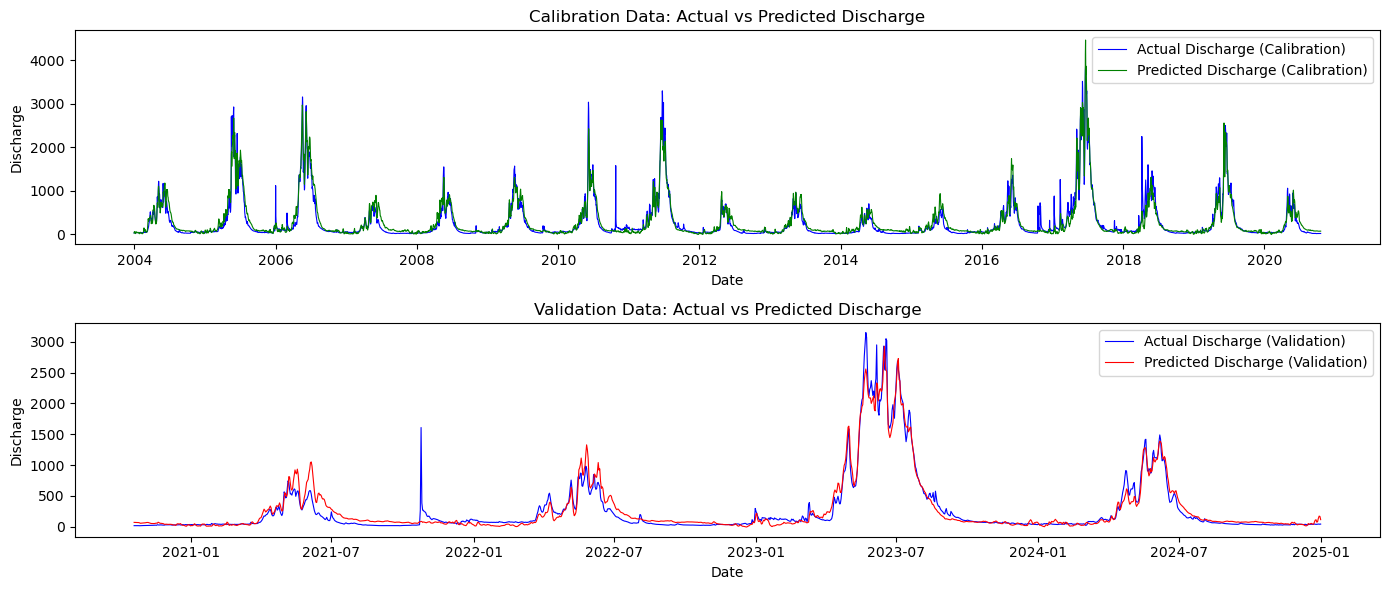

In [6]:
df = pd.read_csv(r'C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\3_Data_Download\3_All_Rasters\final_data_test.csv')
# Function to compute Nash-Sutcliffe Efficiency (NSE)
def nse(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

# Function to compute Kling-Gupta Efficiency (KGE)
def kge(y_true, y_pred):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = np.std(y_pred) / np.std(y_true)
    beta = np.mean(y_pred) / np.mean(y_true)
    return 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

# Function to compute Percent Bias (PBIAS)
def pbias(y_true, y_pred):
    return 100 * (np.sum(y_pred - y_true) / np.sum(y_true))

# Load dataset and preprocess
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Define features (X) and target (y)
X = feature_df
y = df['Discharge']

# Normalize features using Min-Max Scaling
scaler_y = MinMaxScaler()
X_scaled = X
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Create sequences for LSTM (using a lookback window of 30 days)
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

lookback = 90  # 30 days
X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback)

# Split into calibration (80%) and validation (20%) sets
calibration_size = int(0.8 * len(X_seq))
X_calibration, X_validation = X_seq[:calibration_size], X_seq[calibration_size:]
y_calibration, y_validation = y_seq[:calibration_size], y_seq[calibration_size:]

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, X.shape[1])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train LSTM model
history = model.fit(X_calibration, y_calibration, epochs=50, batch_size=16, validation_data=(X_validation, y_validation), verbose=1)

# Make predictions
y_calibration_pred = model.predict(X_calibration)
y_validation_pred = model.predict(X_validation)

# Convert predictions back to original scale
y_calibration_pred = scaler_y.inverse_transform(y_calibration_pred)
y_validation_pred = scaler_y.inverse_transform(y_validation_pred)
y_calibration = scaler_y.inverse_transform(y_calibration.reshape(-1, 1))
y_validation = scaler_y.inverse_transform(y_validation.reshape(-1, 1))

# Evaluate performance
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    nse_value = nse(y_true, y_pred)
    kge_value = kge(y_true, y_pred)
    pbias_value = pbias(y_true, y_pred)

    print(f"\n🔵 **{dataset_name} Performance**")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Nash-Sutcliffe Efficiency (NSE): {nse_value:.4f}")
    print(f"Kling-Gupta Efficiency (KGE): {kge_value:.4f}")
    print(f"Percent Bias (PBIAS): {pbias_value:.4f}")

# Evaluate model
evaluate_model(y_calibration, y_calibration_pred, "Calibration (Training) Data")
evaluate_model(y_validation, y_validation_pred, "Validation (Testing) Data")

# Plot actual vs predicted discharge for both Calibration and Validation sets
plt.figure(figsize=(14, 6))

# Plot Calibration Data
plt.subplot(2, 1, 1)
plt.plot(df['date'][lookback:calibration_size+lookback], y_calibration, label='Actual Discharge (Calibration)', color='blue', linewidth=0.8)
plt.plot(df['date'][lookback:calibration_size+lookback], y_calibration_pred, label='Predicted Discharge (Calibration)', color='green', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Calibration Data: Actual vs Predicted Discharge')
plt.legend()

# Plot Validation Data
plt.subplot(2, 1, 2)
plt.plot(df['date'][calibration_size+lookback:], y_validation, label='Actual Discharge (Validation)', color='blue', linewidth=0.8)
plt.plot(df['date'][calibration_size+lookback:], y_validation_pred, label='Predicted Discharge (Validation)', color='red', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Validation Data: Actual vs Predicted Discharge')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
results_df_cal = pd.DataFrame({
    "Actual_Calibration": y_calibration.flatten(),
    "Predicted_Calibration": y_calibration_pred.flatten()
})


results_df_val = pd.DataFrame({
    "Actual_Calibration": y_validation.flatten(),
    "Predicted_Calibration": y_validation_pred.flatten()
})



rresults_df = pd.concat([results_df_cal, results_df_val], axis=0, ignore_index=True)
rresults_df.to_excel(r'C:\Users\maharjan\OneDrive - Chapman University\Desktop\Snow\6_Results\2d_SA_lstm_new.xlsx')